In [1]:
from z3 import *
from sklearn.datasets import make_blobs

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import itertools
import time

# Data Generation

In [3]:
NUM_FEATURES = 2
NUM_CLASSES = 3

COLORS = np.array(list(mcolors.TABLEAU_COLORS.keys()))

In [4]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES)

In [5]:
def plot(x, y):
  plt.scatter(*x.T, color=COLORS[y])

def plot_boundry(x, y, model, h=0.01, alpha=0.5):
  x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
  y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  z = model(np.vstack([xx.ravel(), yy.ravel()]).T)
  z = z.reshape(xx.shape)
  plt.contourf(xx, yy, z, levels=list(range(-1, NUM_CLASSES)), colors=COLORS, alpha=alpha)

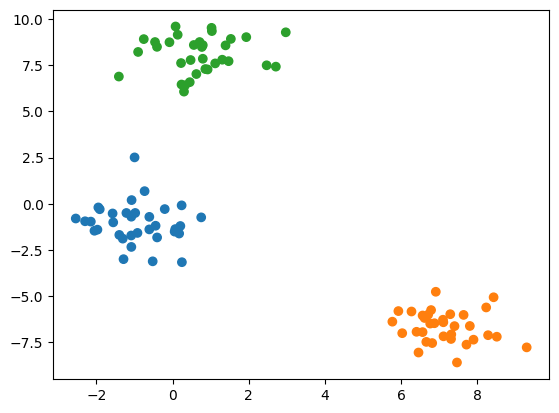

In [6]:
plot(X, y)

# Misc 

In [30]:
def quantize_X(x, b=8):
    
    xq = x.copy()
    xd = x.copy()
    for i in range(x.shape[1]):
        s=(2**b-1)/np.max(abs(x), axis=0)[i]
        xq[:,i] = np.round(s*x[:,i])
        xd[:,i] = xq[:,i]/s

    return xq, xd

# z-threeml

In [8]:
def get_value(x):
  if is_int_value(x):
    return x.as_long()
  if is_rational_value(x):
    return x.numerator_as_long() / x.denominator_as_long()
  if is_algebraic_value(x):
    return x.approx()
  raise ValueError(f"I don't know what {x} is")

def argmax(logits, ix, max_val):
    # Based on http://www.hakank.org/z3/argmax.py
    terms = []
    terms.append(Or([max_val == logits[i] for i in range(len(logits))]))
    for i in range(len(logits)):
        terms.append((ix == i) == (logits[i] == max_val))
    return terms

def maximum(logits, max_val):
    # Based on http://www.hakank.org/z3/max.py
    terms = []
    terms.append(Or([max_val == logits[i] for i in range(len(logits))]))
    for i in range(len(logits)):
        terms.append(max_val >= logits[i])
    return terms

In [9]:
class z3Linear:
  def __init__(self, n_features, dtype=Real):
    self.w = np.array([dtype(f"w_{i}") for i in range(n_features)])
    self.b = np.array([dtype("b")])
    ## jje: init w, b as Real variables

  def forward(self, x):
    return x @ self.w + self.b
    # jje: what is that @ decorator in this function?

  def pred(self, x):
    logits = self.forward(x)
    return logits > 0

  def realize(self, model):
    self.w = np.array([get_value(model[w]) for w in self.w.ravel()]).reshape(*self.w.shape)
    self.b = np.array([get_value(model[b]) for b in self.b.ravel()]).reshape(*self.b.shape)
    return self
    
    # jje: way to get the values back if the model returned SAT

# This is the loss that should be paired with a 2 class classifier
def threshold_loss(logits, y):
  """Losses return lists or lists of constraints."""
  return [np.vectorize(lambda l, y: If(bool(y == 0), l < 0, l > 0))(logits, y)]
  # jje: if the y (class) is 0, then logit=wx+b should be less than 0 (below the line), pos otherwise
  

In [10]:
class z3MultiClassLinear(z3Linear):
    def __init__(self, n_features, n_output, dtype=Real):
        self.w = np.array(
            [[dtype(f"w_{i},{j}") for j in range(n_output)]
             for i in range(n_features)]
        )
        self.b = np.array([dtype(f"b_{i}") for i in range(n_output)])
        # jje: there will be more than 1 line that separate the classes

    def pred(self, x):
        logits = self.forward(x)
        return np.argmax(logits, axis=-1)

    def loss(self, logits, y):
        terms = []
        for i, (l, y_) in enumerate(zip(logits, y)):
            ts = []
            ix = Int(f"argmax_{i}")
            max_val = Real(f"max_{i}")
            ts.extend(maximum(l, max_val)) # jje: one of the values is the max
            ts.extend(argmax(l, ix, max_val)) # jje: clause for the argmax
            ts.append(ix == y_) # jje: that the idx that max is the class
            terms.append(ts)
        return terms

# This loss is paired with anything that has more than 2 classes
def multiclass_loss(logits, y):
    """Losses return lists of lists of constraints."""
    terms = []
    for i, (l, y_) in enumerate(zip(logits, y)):
        ts = []
        ix = Int(f"argmax_{i}")
        max_val = Real(f"max_{i}")
        ts.extend(maximum(l, max_val))
        ts.extend(argmax(l, ix, max_val))
        ts.append(ix == y_)
        terms.append(ts)
    return terms

In [11]:
def relu(x):
    # Based on https://gist.github.com/philzook58/5aab67b65b476bb55e6b9c403ccabed2
    return np.vectorize(lambda y: If(y >= 0, y, RealVal(0)))(x)

class z3MLP(z3MultiClassLinear):
    def __init__(self, n_features, n_hidden, n_output, dtype=Real):
        self.ws = []
        self.bs = []
        if not isinstance(n_hidden, list):
            n_hidden = [n_hidden]
        for i, (in_, out) in enumerate(zip([n_features, *n_hidden], [*n_hidden, n_output])):
            w = np.array([
                [dtype(f"w_{i},{j},{k}") for k in range(out)]
                for j in range(in_)
            ])
            self.ws.append(w)
            b = np.array([dtype(f"b_{i},{j}") for j in range(out)])
            self.bs.append(b)
        self.relu = relu

    def forward(self, x):
        for w, b in zip(self.ws[:-1], self.bs[:-1]):
            x = x @ w + b
            x = self.relu(x)
        return x @ self.ws[-1] + self.bs[-1]

    def realize(self, m):
        self.ws = [
            np.array([get_value(m[w]) for w in ws.ravel()]).reshape(*ws.shape)
            for ws in self.ws
        ]
        self.bs = [
            np.array([get_value(m[b]) for b in bs.ravel()]).reshape(*bs.shape)
            for bs in self.bs
        ]
        self.relu = lambda x: np.maximum(x, 0)
        return self

In [12]:
def train(x, y, model, loss):
    """The 'training loop'."""
    # Create a symbolic representation of the logits created by the model for every datapoint.
    logits = model.forward(x)
    # Create a constraint that the symbolic logits represent the right answer
    return loss(logits, y)

In [13]:
seed = 42

sat
Model Parameters:
 w: [ 0.23427283 -0.01846165]
 b: [-0.10154311]


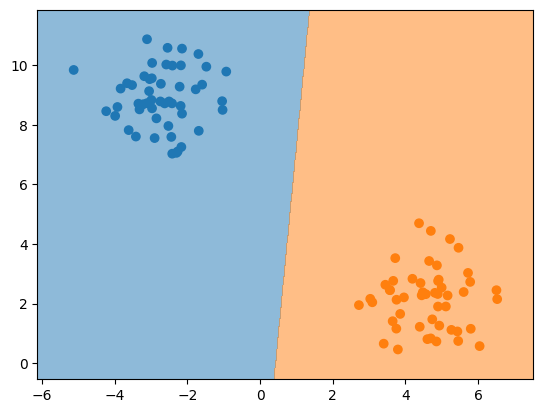

In [14]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)

ml = z3Linear(NUM_FEATURES)
terms = train(X, y, ml, threshold_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [ 1 -1]
 b: [1]


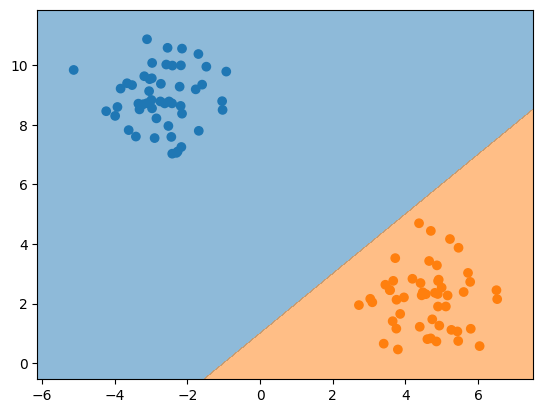

In [30]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)

ml = z3Linear(NUM_FEATURES, dtype=Int)
terms = train(X, y, ml, threshold_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [[-0.54157959  0.40776675 -0.1006123 ]
 [ 0.22401833  0.11546978 -0.06097521]]
 b: [-3.75409669 -2.30942743 -1.28925726]
CPU times: user 4.61 s, sys: 411 ms, total: 5.02 s
Wall time: 2.99 s


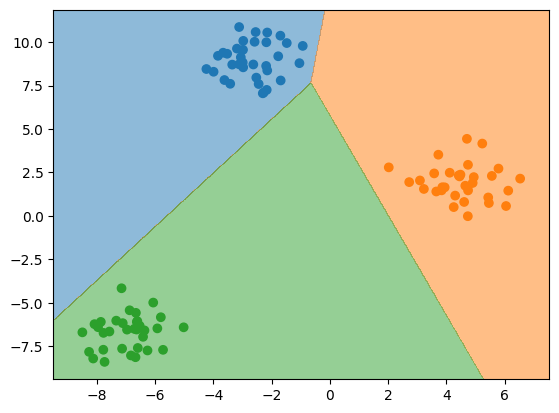

In [31]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(X, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [[1 -1 -92864220445760056286212784189]
 [-4873357652754562499999999998 -4873357652754562500000000004 1]]
 b: [4 41 -434387443111760770180556601495]
CPU times: user 2.51 s, sys: 417 ms, total: 2.93 s
Wall time: 3.33 s


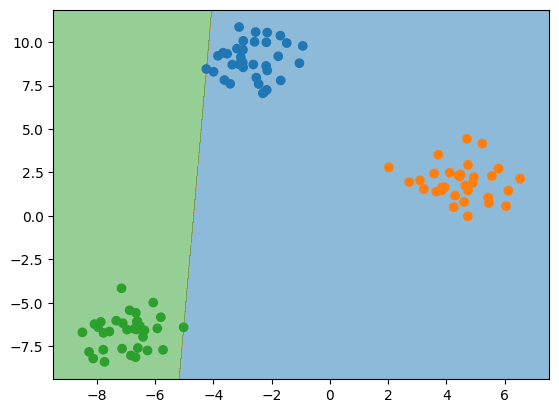

In [32]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES, dtype=Int)
terms = train(X, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

## Try to pass in quantized input

In [33]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)
ml = z3Linear(NUM_FEATURES)
Xq, Xd = quantize_X(X)

In [34]:
display(X[0])
display(Xq[0])
display(Xd[0])

array([-2.98837186,  8.82862715])

array([-117.,  207.])

array([-2.99431206,  8.82109338])

sat
Model Parameters:
 w: [ 0.00331795 -0.0033698 ]
 b: [0.30330758]
CPU times: user 60.5 ms, sys: 9.26 ms, total: 69.8 ms
Wall time: 69.6 ms


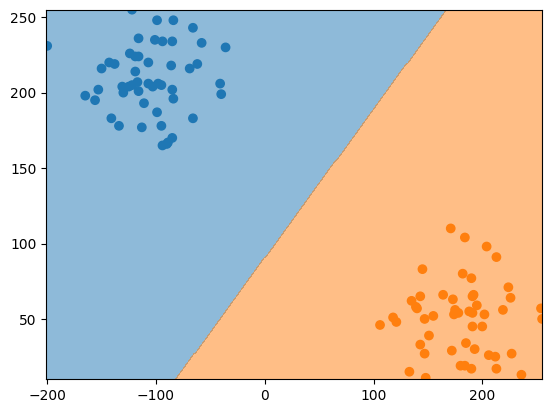

In [35]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)
ml = z3Linear(NUM_FEATURES)
Xq, Xd = quantize_X(X)

terms = train(Xq, y, ml, threshold_loss)
s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(Xq, y, ml.pred, h = 1)
  plot(Xq, y)

sat
Model Parameters:
 w: [ 0.01176471 -0.01764706]
 b: [0.48235294]
CPU times: user 51.3 ms, sys: 2.23 ms, total: 53.6 ms
Wall time: 53.1 ms


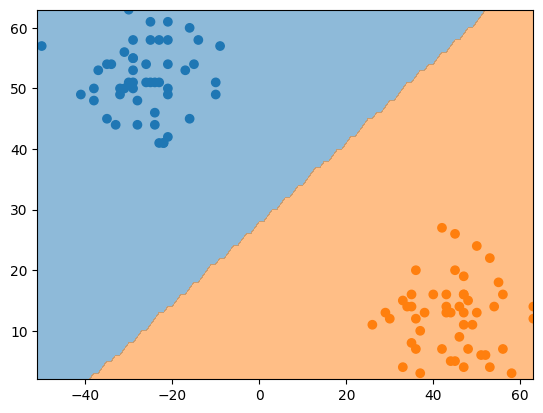

In [36]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)
ml = z3Linear(NUM_FEATURES)
Xq, Xd = quantize_X(X, b=6)

terms = train(Xq, y, ml, threshold_loss)
s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(Xq, y, ml.pred, h = 1)
  plot(Xq, y)

sat
Model Parameters:
 w: [ 0.12992778 -0.07824544]
 b: [0.29876946]
CPU times: user 150 ms, sys: 2.41 ms, total: 152 ms
Wall time: 152 ms


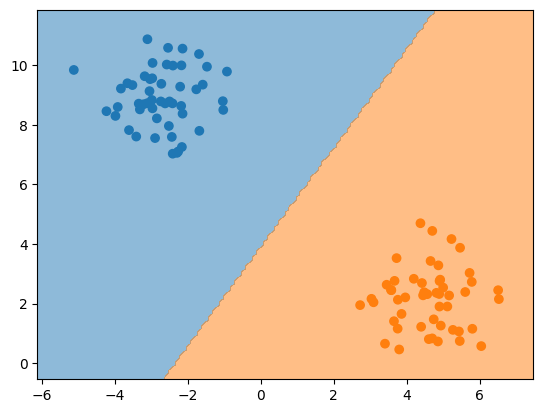

In [37]:
%%time
ml = z3Linear(NUM_FEATURES)
terms = train(X, y, ml, threshold_loss)
s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred, h = 0.1)
  plot(X, y)

sat
Model Parameters:
 w: [[-0.00273857  0.00395786  0.00017083]
 [ 0.00693031 -0.00199826 -0.0064536 ]]
 b: [-0.9350312  -0.40154906 -0.60682863]
CPU times: user 232 ms, sys: 3.19 ms, total: 235 ms
Wall time: 235 ms


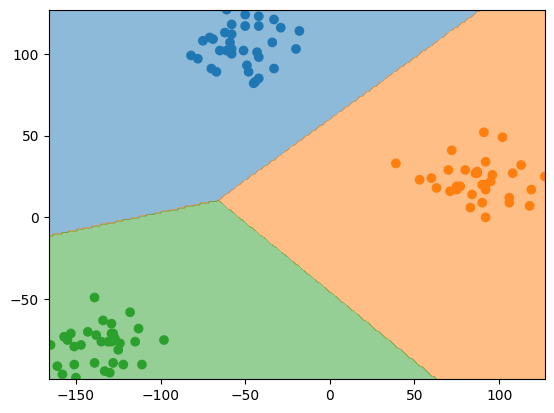

In [38]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)
Xq, Xd = quantize_X(X, b=7)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(Xq, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(Xq, y, ml.pred, h=1)
  plot(Xq, y)

sat
Model Parameters:
 w: [[-0.62387299  0.31525252 -0.1829057 ]
 [ 0.24578263 -0.31134908 -0.03921091]]
 b: [-4.20721978 -1.48808078 -1.74238036]
CPU times: user 1.24 s, sys: 5.65 ms, total: 1.25 s
Wall time: 1.25 s


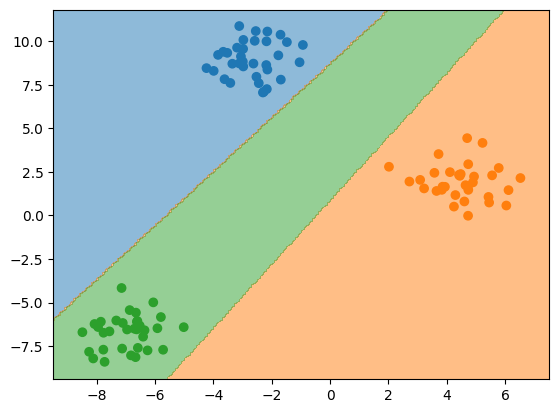

In [39]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(X, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred, h=0.1)
  plot(X, y)

# Not Linearly Separable

## XOR

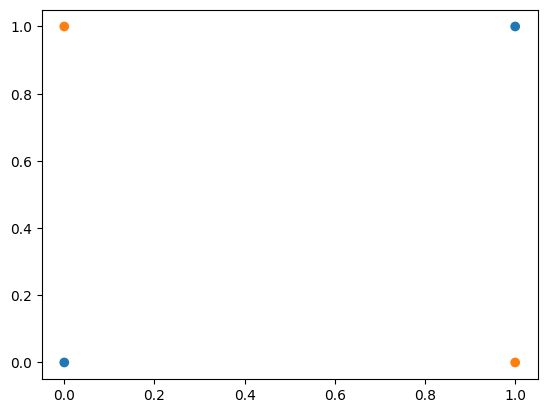

In [40]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]])
y = np.array([0, 1, 1, 0])

plot(X, y)

In [41]:
ml = z3Linear(2)
terms = train(X, y, ml, threshold_loss)

s = Solver()
s.add(*itertools.chain(*terms))
print(s.check(), "as expected")

unsat as expected


In [42]:
ml = z3MLP(2, 3, 2, dtype=Int)  # This takes forwver with a dtype of Real
terms = train(X, y, ml, multiclass_loss)

sat
Model Parameters:
 ws: [array([[ 2,  0, -1],
       [-1,  0,  1]]), array([[ 0,  2],
       [ 0, -1],
       [ 0,  6]])]
 bs: [array([1, 0, 0]), array([ 1, -4])]
CPU times: user 49.9 ms, sys: 4.82 ms, total: 54.7 ms
Wall time: 42.3 ms


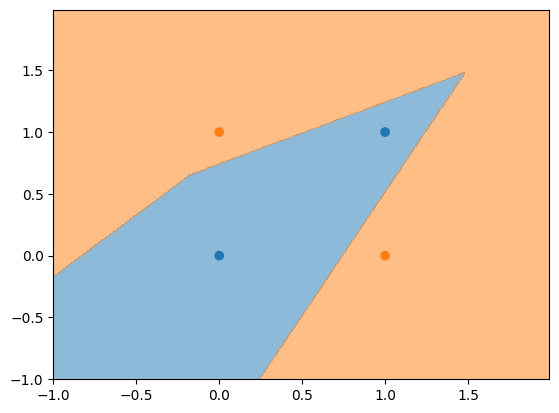

In [43]:
%%time
s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  ml = ml.realize(s.model())

  print("Model Parameters:")
  print(f" ws: {ml.ws}")
  print(f" bs: {ml.bs}")
  plot_boundry(X, y, ml.pred)
  plot(X, y)

## More Realistic Non-separable

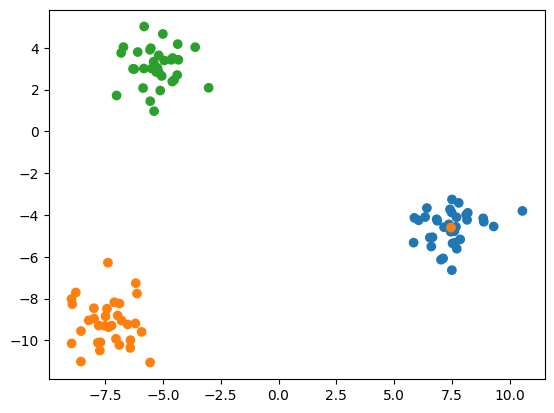

In [44]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=128)

# Create a datapoint in the wrong cluster
X_ns = np.concatenate([X, np.mean(X[y == 0], axis=0, keepdims=True)], axis=0)
y_ns = np.concatenate([y, [1]], axis=0)

plot(X_ns, y_ns)

In [45]:
ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(X_ns, y_ns, ml, multiclass_loss)

s = Solver()
s.set(unsat_core=True)
for i, ts in enumerate(terms):
  for j, t in enumerate(ts):
    if j == (len(ts) - 1):
      s.assert_and_track(t, f"d{i}")
    else:
      s.add(t)
print(s.check(), "as expected")

unsat as expected


In [46]:
def plot_unsat(x, y, unsat):
    plt.scatter(*x.T, color=COLORS[y])
    plt.scatter(*x[unsat].T, color=COLORS[y[unsat]], edgecolor="k")

There are 4 constraints in the UNSAT-core: [d100, d6, d0, d3]


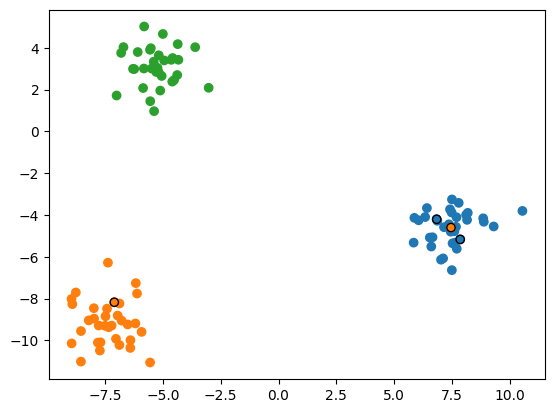

In [47]:
c = s.unsat_core()
print(f"There are {len(c)} constraints in the UNSAT-core: {c}")

unsat = [int(str(u)[1:]) for u in c]

plot_unsat(X_ns, y_ns, unsat)

In [48]:
def plot_max(x, y, y_pred):
    plt.scatter(*x.T, color=COLORS[y])
    plt.scatter(*x[y != y_pred].T, color=COLORS[y[y != y_pred]], edgecolor=COLORS[y_pred[y != y_pred]])

In [49]:
o = Optimize()  # A MaxSAT solver, it takes longer
for i, ts in enumerate(terms):
    for j, t in enumerate(ts):
        if j == (len(ts) - 1):
            o.add_soft(t)
        else:
            o.add(t)
status = o.check()
print(status)
if status == sat:
    ml = ml.realize(o.model())
    y_hat = ml.pred(X_ns)
    print(f"Model Accuracy: {sum(y_hat == y_ns)/len(y_ns)*100:.4f}")

    plot_max(X_ns, y_ns, y_hat)
    plot_boundry(X_ns, y_ns, ml.pred, alpha=0.3)

unknown


# Simple Scaling

In [35]:
# times = []
# num_examples = [2 ** i for i in range(16)]

# for num_ex in num_examples:
#     status = unsat
#     while status == unsat:
#         X, y = make_blobs(num_ex, n_features=NUM_FEATURES, centers=NUM_CLASSES)
#         ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
#         terms = train(X, y, ml, multiclass_loss)
#         s = Solver()
#         s.add(*itertools.chain(*terms))
#         tic = time.time()
#         status = s.check()
#         toc = time.time()
#     times.append(toc - tic)
#     print(f"Solved for {num_ex} examples.")

In [36]:
# plt.plot(num_examples, times)
# plt.xscale("log")
# plt.ylabel("seconds")
# plt.xlabel("Number of Examples");

In [16]:
times_noquant = []
times_quant = []
num_examples = [2 ** i for i in range(12)]

for num_ex in num_examples:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=NUM_FEATURES, centers=NUM_CLASSES)
        ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
        Xq, _ = quantize_X(X)
        terms1 = train(X, y, ml, multiclass_loss)
        terms2 = train(Xq, y, ml, multiclass_loss)

        # check without quant
        s = Solver()
        s.add(*itertools.chain(*terms1))
        tic1 = time.time()
        status = s.check()
        print(f"status no quant: {status}")
        toc1 = time.time()
        
        # check with quant
        s = Solver()
        s.add(*itertools.chain(*terms2))
        tic2 = time.time()
        status = s.check()
        print(f"status quant: {status}")
        toc2 = time.time()
    
    times_noquant.append(toc1 - tic1)
    times_quant.append(toc2 - tic2)
    
    print(f"Solved for {num_ex} examples.")

status no quant: sat
status quant: sat
Solved for 1 examples.
status no quant: sat
status quant: sat
Solved for 2 examples.
status no quant: sat
status quant: sat
Solved for 4 examples.
status no quant: sat
status quant: sat
Solved for 8 examples.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 16 examples.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 32 examples.
status no quant: sat
status quant: sat
Solved for 64 examples.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 128 examples.
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 256 examples.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 512 examples.
status no quant: sat
status quant: sat
Solved for 1024 examples.
status no quant: sat
status quant: sat
Solved fo

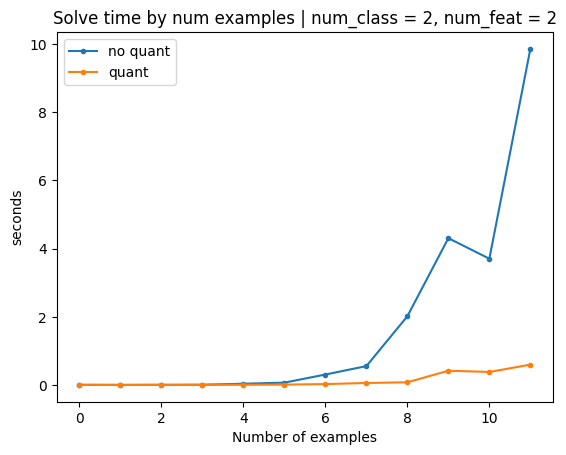

In [17]:
plt.plot(times_noquant, label='no quant', marker='.')
plt.plot(times_quant, label = 'quant', marker = '.')
plt.ylabel("seconds")
plt.xlabel("Number of examples")
plt.title("Solve time by num examples | num_class = 2, num_feat = 2")
plt.legend()

In [49]:
times_noquant = []
times_quant = []
num_ex = 50
num_features = [2**i for i in range(5)]

for num_feat in num_features:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=num_feat, centers=NUM_CLASSES)
        ml = z3MultiClassLinear(num_feat, NUM_CLASSES)
        Xq, _ = quantize_X(X)
        terms1 = train(X, y, ml, multiclass_loss)
        terms2 = train(Xq, y, ml, multiclass_loss)

        # check without quant
        s = Solver()
        s.add(*itertools.chain(*terms1))
        tic1 = time.time()
        status = s.check()
        print(f"status no quant: {status}")
        toc1 = time.time()
        
        # check with quant
        s = Solver()
        s.add(*itertools.chain(*terms2))
        tic2 = time.time()
        status = s.check()
        print(f"status quant: {status}")
        toc2 = time.time()
    
    times_noquant.append(toc1 - tic1)
    times_quant.append(toc2 - tic2)
    
    print(f"Solved for {num_feat} features.")

status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 1 features.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 2 features.
status no quant: sat
status quant: sat
Solved for 4 features.
status no quant: sat
status quant: sat
Solved for 8 features.
status no quant: sat
status quant: sat
Solved for 16 features.


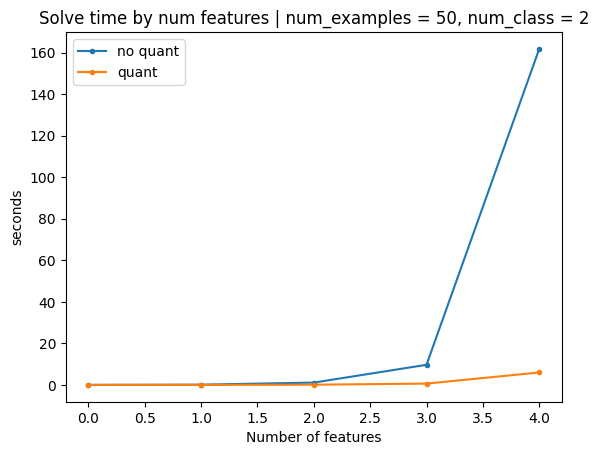

In [50]:
plt.plot(times_noquant, label='no quant',marker='.')
plt.plot(times_quant, label = 'quant',marker='.')
plt.ylabel("seconds")
plt.xlabel("Number of features")
plt.title("Solve time by num features | num_examples = 50, num_class = 2")
plt.legend()

In [56]:
# with increased # classes, harder to separate
times_noquant = []
times_quant = []
num_ex = 50
num_classes = [2**i for i in range(5)]

for num_class in num_classes:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=NUM_FEATURES, centers=num_class)
        ml = z3MultiClassLinear(NUM_FEATURES, num_class)
        Xq, _ = quantize_X(X)
        terms1 = train(X, y, ml, multiclass_loss)
        terms2 = train(Xq, y, ml, multiclass_loss)

        # check without quant
        s = Solver()
        s.add(*itertools.chain(*terms1))
        tic1 = time.time()
        status = s.check()
        print(f"status no quant: {status}")
        toc1 = time.time()
        
        # check with quant
        s = Solver()
        s.add(*itertools.chain(*terms2))
        tic2 = time.time()
        status = s.check()
        print(f"status quant: {status}")
        toc2 = time.time()
    
    times_noquant.append(toc1 - tic1)
    times_quant.append(toc2 - tic2)
    
    print(f"Solved for {num_class} classes.")

status no quant: sat
status quant: sat
Solved for 1 classes.
status no quant: sat
status quant: sat
Solved for 2 classes.
status no quant: sat
status quant: sat
Solved for 4 classes.
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 8 classes.
status no quant: sat
status quant: sat
Solved for 16 classes.


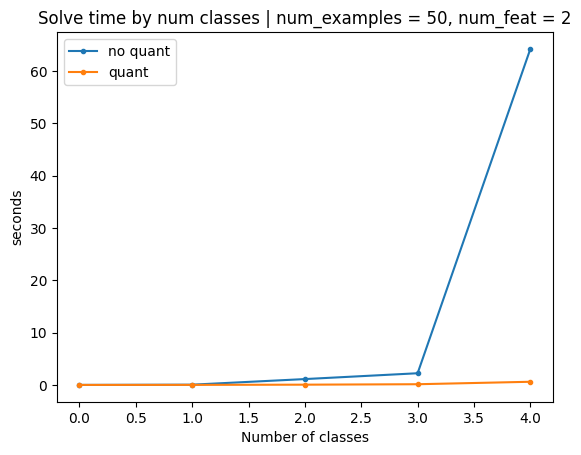

In [57]:
plt.plot(times_noquant, label='no quant', marker='.')
plt.plot(times_quant, label = 'quant', marker='.')
plt.ylabel("seconds")
plt.xlabel("Number of classes")
plt.title("Solve time by num classes | num_examples = 50, num_feat = 2")
plt.legend()

**Some observations**

* Quantization (to int 2**8 range) helps a lot for scaling #classes/#features/#examples
* **Scaling # features** is the slowest (using the non-quantized original data); scaling # features with fixed num class = 2 does not result in any unsat instances.
* **Scaling # classes** result in a few "unsat" instances as # classes go up (random data generation produces overlapping classes). Highlights the need for handling non separable data samples (Optimize() etc).
* **Scaling # examples** is the fastest. Probably because the examples are in blobs.

Just testing on # features 50 and # example 10 (input quantized) -- taking forever. Makes me think that realistic data could take quite long to solve? But I'm going to try with MNIST/CIFAR (or tabular data if I can't get them to work).

In [15]:
times = []
num_ex = 10
num_features = [i for i in range(100, 1000, 100)] #[i for i in range(50, 110, 10)]

for num_feat in num_features:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=num_feat, centers=2)
        ml = z3MultiClassLinear(num_feat, NUM_CLASSES)
        Xq, _ = quantize_X(X)
        terms2 = train(Xq, y, ml, multiclass_loss)
        
        # check with quant
        s = Solver()
        s.add(*itertools.chain(*terms2))
        tic2 = time.time()
        status = s.check()
        print(f"status quant: {status}")
        toc2 = time.time()
    
    times.append(toc2 - tic2)
    
    print(f"Solved for {num_feat} features.")

status quant: sat
Solved for 100 features.
status quant: sat
Solved for 200 features.
status quant: sat
Solved for 300 features.
status quant: sat
Solved for 400 features.


KeyboardInterrupt: 

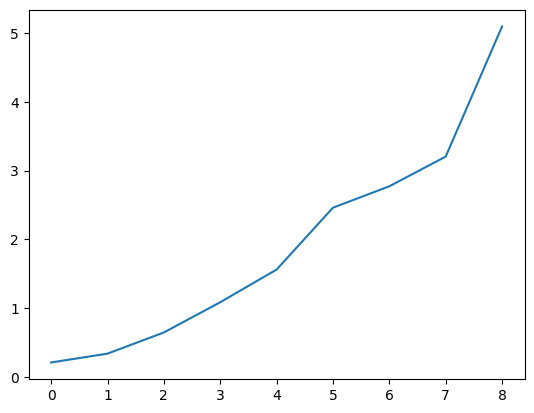

In [41]:
plt.plot(times)

## Actual data for multi-class classification

    1. subsample class based
    2. PCA on the whole train then 1.

In [15]:
import torchvision
import torchvision.datasets as datasets
import torch
from sklearn.decomposition import PCA

In [16]:
# trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True)
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)

In [17]:
trainset.train_labels.unique()

/Users/jay.je/miniforge3/envs/sat_env/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [18]:
trainset.data[0].shape

torch.Size([28, 28])

In [19]:
print(trainset.data.max())
print(trainset.data.min())

tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)


In [ ]:
pca = PCA(n_components = 100)
construct_time = []
solve_time = []
test_acc = []
test_time = []
sat_ls = []

for train_num in [200]:#range(10, 20, 10):
    samples = []
    labels = []
    for i in range(train_num):
        samples.append(trainset.data[i].flatten().numpy())
        labels.append(trainset.train_labels[i].numpy())
    samples = np.array(samples)
    labels = np.array(labels)
    samples = pca.fit_transform(samples)
    samples, _ = quantize_X(samples)
    print(f"samples shape: {samples.shape}")

    # construct
    ml = z3MultiClassLinear(100, 10)
    tic = time.time()
    terms = train(samples, labels, ml, multiclass_loss)
    toc = time.time()
    construct_time.append(toc-tic)
    print(f"Train size {train_num} constructed in {toc-tic}")

    # solve    
    s = Solver()
    s.add(*itertools.chain(*terms))
    tic = time.time()
    status = s.check()
    sat_ls.append(status)
    print(f"status: {status}")
    toc = time.time()
    solve_time.append(toc-tic)
    print(f"Train size {train_num} solved in {toc-tic}")

    # manual solve to avoid changing code (some weights are None)
    m = s.model()
    w_t = np.array([get_value(s.model()[w]) if m[w] is not None else 0 for w in ml.w.ravel() ]).reshape(*ml.w.shape)
    b_t = np.array([get_value(s.model()[b]) if m[b] is not None else 0 for b in ml.b.ravel() ]).reshape(*ml.b.shape)

    ml.w = w_t
    ml.b = b_t

    # pred
    tic = time.time()
    y_pred = ml.pred(test_samples)
    toc = time.time()
    acc = sum(y_pred==test_labels)/len(y_pred)
    test_acc.append(acc)
    test_time.append(toc-tic)
    print(f"Train size {train_num} accuracy {acc}, pred time {toc-tic}")

/Users/jay.je/miniforge3/envs/sat_env/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


samples shape: (200, 100)
Train size 200 constructed in 20.17458415031433


In [31]:
pca = PCA(n_components = 5)
test_samples = []
test_labels = []
for i in range(200, 1000):
    test_samples.append(trainset.test_data[i].flatten().numpy())
    test_labels.append(trainset.test_labels[i].numpy())

test_samples = np.array(test_samples)
test_labels = np.array(test_labels)
test_samples_q = pca.fit_transform(test_samples)

/Users/jay.je/miniforge3/envs/sat_env/lib/python3.10/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/jay.je/miniforge3/envs/sat_env/lib/python3.10/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [32]:
pca = PCA(n_components=5)
train_data = pca.fit_transform(trainset.data.flatten(start_dim=1))
train_label = trainset.targets

In [33]:
samples = {}
for i in range(10):
    samples[i] = []
train_labels = []

for i in range(1000):
    lab = int(train_label[i])

    if len(samples[lab])<3:
        samples[lab].append(train_data[i])
        train_labels.append(lab)

In [34]:
train_samples = []
for k in samples:
    train_samples += samples[k]
train_samples =np.array(train_samples)
train_labels =np.array(train_labels)

In [38]:
train_samples_q, train_samples_d = quantize_X(train_samples)

In [39]:
train_samples

array([[1011.71837587,  294.85703827, -596.33956104,  460.76619688,
        -827.27522188],
       [1037.65134435,  354.92983593, -523.73106293,  535.39926707,
        -903.39527757],
       [ 610.29259261,  239.78961394, -673.52004503,  678.3453701 ,
         371.00681957],
       [-799.12703657,  607.19721723, -273.65124001, -105.87823655,
          -1.85322555],
       [-726.51398473,  156.98556144,  248.19078763,  -72.38412744,
        -133.26318624],
       [-868.90677004,   81.5471579 ,  133.41752914,  -76.00983604,
        -504.60992793],
       [ 184.46887015, -221.33200355, -591.35952658,  -51.90609556,
         327.40014158],
       [  93.35325744,   -2.83052851, -156.83107413, -336.43104994,
         130.87600172],
       [ 767.0462627 , 1054.28570039,  186.78568521,  118.71555825,
         695.78622397],
       [ 513.34489624,  310.7732654 ,  104.08045639,  882.25532226,
         684.31440263],
       [-146.20239709,  643.42604115,  251.31106289,  708.16404226,
         308

In [40]:
train_samples_q

array([[ 249.,   71., -137.,  133., -234.],
       [ 255.,   86., -121.,  155., -255.],
       [ 150.,   58., -155.,  196.,  105.],
       [-196.,  147.,  -63.,  -31.,   -1.],
       [-179.,   38.,   57.,  -21.,  -38.],
       [-214.,   20.,   31.,  -22., -142.],
       [  45.,  -54., -136.,  -15.,   92.],
       [  23.,   -1.,  -36.,  -97.,   37.],
       [ 188.,  255.,   43.,   34.,  196.],
       [ 126.,   75.,   24.,  255.,  193.],
       [ -36.,  156.,   58.,  205.,   87.],
       [  69.,  201.,  255.,   82.,   46.],
       [ -13.,  -95.,   43., -151.,  -87.],
       [ -75., -113., -160.,  -27.,   10.],
       [  83., -121.,   60., -192.,  138.],
       [  30.,   76.,    6.,  161.,   -8.],
       [-151.,   59.,  -79., -130., -129.],
       [-147.,   48.,  -87.,   -4., -132.],
       [  59.,  -36., -148., -161.,  100.],
       [ -52.,   48.,   28.,  -78.,  -59.],
       [  -4.,  -21.,  -28., -167.,  -37.],
       [ -34., -211., -112.,  116.,  -97.],
       [-160.,  -30.,  -78.,  -7

In [43]:
print(train_samples.shape)
print(train_labels.shape)

(30, 5)
(30,)


In [45]:
ml = z3MultiClassLinear(5, 10)
terms_m = train(train_samples_q, train_labels, ml, multiclass_loss)

In [ ]:
%%time
s = Solver()
s.set("timeout", 300)
s.add(*itertools.chain(*terms_m))
tic = time.time()
status = s.check()
print(f"status: {status}")
toc = time.time()
m = s.model()

In [81]:
w_t = np.array([get_value(m[w]) if m[w] is not None else 0 for w in ml.w.ravel() ]).reshape(*ml.w.shape)
b_t = np.array([get_value(m[b]) if m[b] is not None else 0 for b in ml.b.ravel() ]).reshape(*ml.b.shape)
ml.w = w_t
ml.b = b_t

In [82]:
y_pred = ml.pred(test_samples_q)

In [83]:
sum(y_pred==test_labels)/len(y_pred)

np.float64(0.11)

In [84]:
print(f"Model accuracy: {sum(y_pred == test_labels)/len(y_pred)}")

Model accuracy: 0.11
